In [1]:
import joblib

In [8]:
import numpy as np
from numpy import logical_and as land
from numpy import logical_not as lnot
from skimage.feature import canny
from skimage.transform import rescale, ProjectiveTransform, warp
from skimage.morphology import dilation, disk
import cv2
import matplotlib.pyplot as plt

In [3]:
SCALE = 0.33

import operator

In [4]:
def find_corners(img, ind):
    contours, h = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)  # Find contours
    contours = sorted(contours, key=cv2.contourArea, reverse=True) 
    polygon = contours[ind] 

    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))

    return polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]

In [38]:
def predict_image(image):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    proc = cv2.GaussianBlur(img.copy(), (7, 7), 0)
    process = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 7, 2)
    process = cv2.bitwise_not(process, process)
    kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]], np.uint8)
    process = cv2.dilate(process, kernel)
    
    
    contours, hierarchy = cv2.findContours(process.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    polygons = []
    flag = 1
    for i in range(4):
        top_l, top_r, bottom_r, bottom_l  = find_corners(process, i)
        width_A = np.sqrt(((bottom_r[0] - bottom_l[0]) ** 2) + ((bottom_r[1] - bottom_l[1]) ** 2))
        width_B = np.sqrt(((top_r[0] - top_l[0]) ** 2) + ((top_r[1] - top_l[1]) ** 2))
        width = max(int(width_A), int(width_B))

        height_A = np.sqrt(((top_r[0] - bottom_r[0]) ** 2) + ((top_r[1] - bottom_r[1]) ** 2))
        height_B = np.sqrt(((top_l[0] - bottom_l[0]) ** 2) + ((top_l[1] - bottom_l[1]) ** 2))
        height = max(int(height_A), int(height_B))

        if flag and (abs(width_A - width_B) < width * 0.2 or abs(height_A - height_B) < height * 0.2):
            et = width * height * 0.68
            h = height * 0.3
            w = width * 0.3
            flag = 0
        elif flag:
            et = width * height * 0.68
            h = height * 0.3
            w = width * 0.3

        if i > 0 and (abs(width_A - width_B) > w or abs(height_A - height_B) > h or abs(height - width) > width * 0.2 or width*height < et):
            continue
        else:
            polygons.append([top_l, top_r, bottom_r, bottom_l])


        dimensions = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1],
                              [0, height - 1]], dtype="float32")
        # Convert to Numpy format
        ordered_corners = [top_l, top_r, bottom_r, bottom_l]
        ordered_corners = np.array(ordered_corners , dtype="float32")# calculate the perspective transform matrix and warp
        # the perspective to grab the screen
        grid = cv2.getPerspectiveTransform(ordered_corners, dimensions)
        res = cv2.warpPerspective(img, grid, (width, height))
    
    dst = np.zeros(img.shape)
    sudoku_digits = [
        np.int16([[-1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [-1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [-1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [-1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [-1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [-1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [-1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [-1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [-1, -1, -1, -1, -1, -1, -1, -1, -1]]),
    ]
    mask = cv2.fillPoly(dst, np.array( [[p[0], p[1], p[2], p[3]] for p in polygons], dtype=np.int32 ), (255,255,255))
    return mask, sudoku_digits

In [34]:
image = cv2.imread("train_0.jpg")

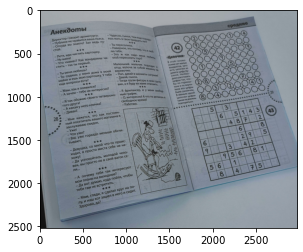

In [35]:
plt.imshow(image)

In [36]:
image = cv2.imread("train_1.jpg")

In [39]:
a, b = predict_image(image)

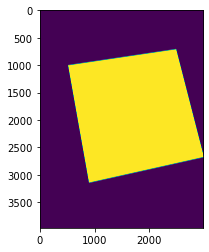

In [40]:
plt.imshow(a)